In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16_bn
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.util import view_as_windows
from tqdm import tqdm
import numpy as np
import os
import cv2
import random
import torchvision
from torchvision import models
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(338)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def patchify(img, patch_size, step_size=None):
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    if step_size is None:
        step_size = patch_size

    if len(img.shape) == 3: # If image has 3 channels
        patches = view_as_windows(img, (patch_size, patch_size, 3), step=step_size)
        patches = patches.reshape(-1, patch_size, patch_size, 3)
    elif len(img.shape) == 2: # If image is grayscale
        patches = view_as_windows(img, (patch_size, patch_size), step=step_size)
        patches = patches.reshape(-1, patch_size, patch_size)
        
    return patches

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
    
def rle_decode(mask_rle, shape):
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(shape)

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, patch_size=256, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.data) * ((1024 // self.patch_size) ** 2)

    def __getitem__(self, idx):
        image_idx = idx // ((1024 // self.patch_size) ** 2)
        patch_idx = idx % ((1024 // self.patch_size) ** 2)

        img_path = self.data.iloc[image_idx, 1]
        image = cv2.imread(os.path.join('./data', img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.medianBlur(image, 5)
        
        mask_rle = self.data.iloc[image_idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        
        image_patches = patchify(image, self.patch_size)
        mask_patches = patchify(mask, self.patch_size)

        if self.transform:
            augmented = self.transform(image=image_patches[patch_idx], mask=mask_patches[patch_idx])
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [4]:
def visualize_grid(images, masks):
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))

    for i, ax in enumerate(axs.flat):
        image, mask = images[i], masks[i]

        # We stack the mask with zero arrays to have the right shape for imshow
        mask_rgb = np.stack([mask*255, np.zeros_like(mask), np.zeros_like(mask)], axis=-1)

        ax.imshow(image, cmap='gray')
        ax.imshow(mask_rgb, alpha=0.3)  # We use alpha to make the mask semi-transparent
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
    ToTensorV2()
])

dataset = SatelliteDataset(csv_file='./data/train_split.csv', transform=transform)

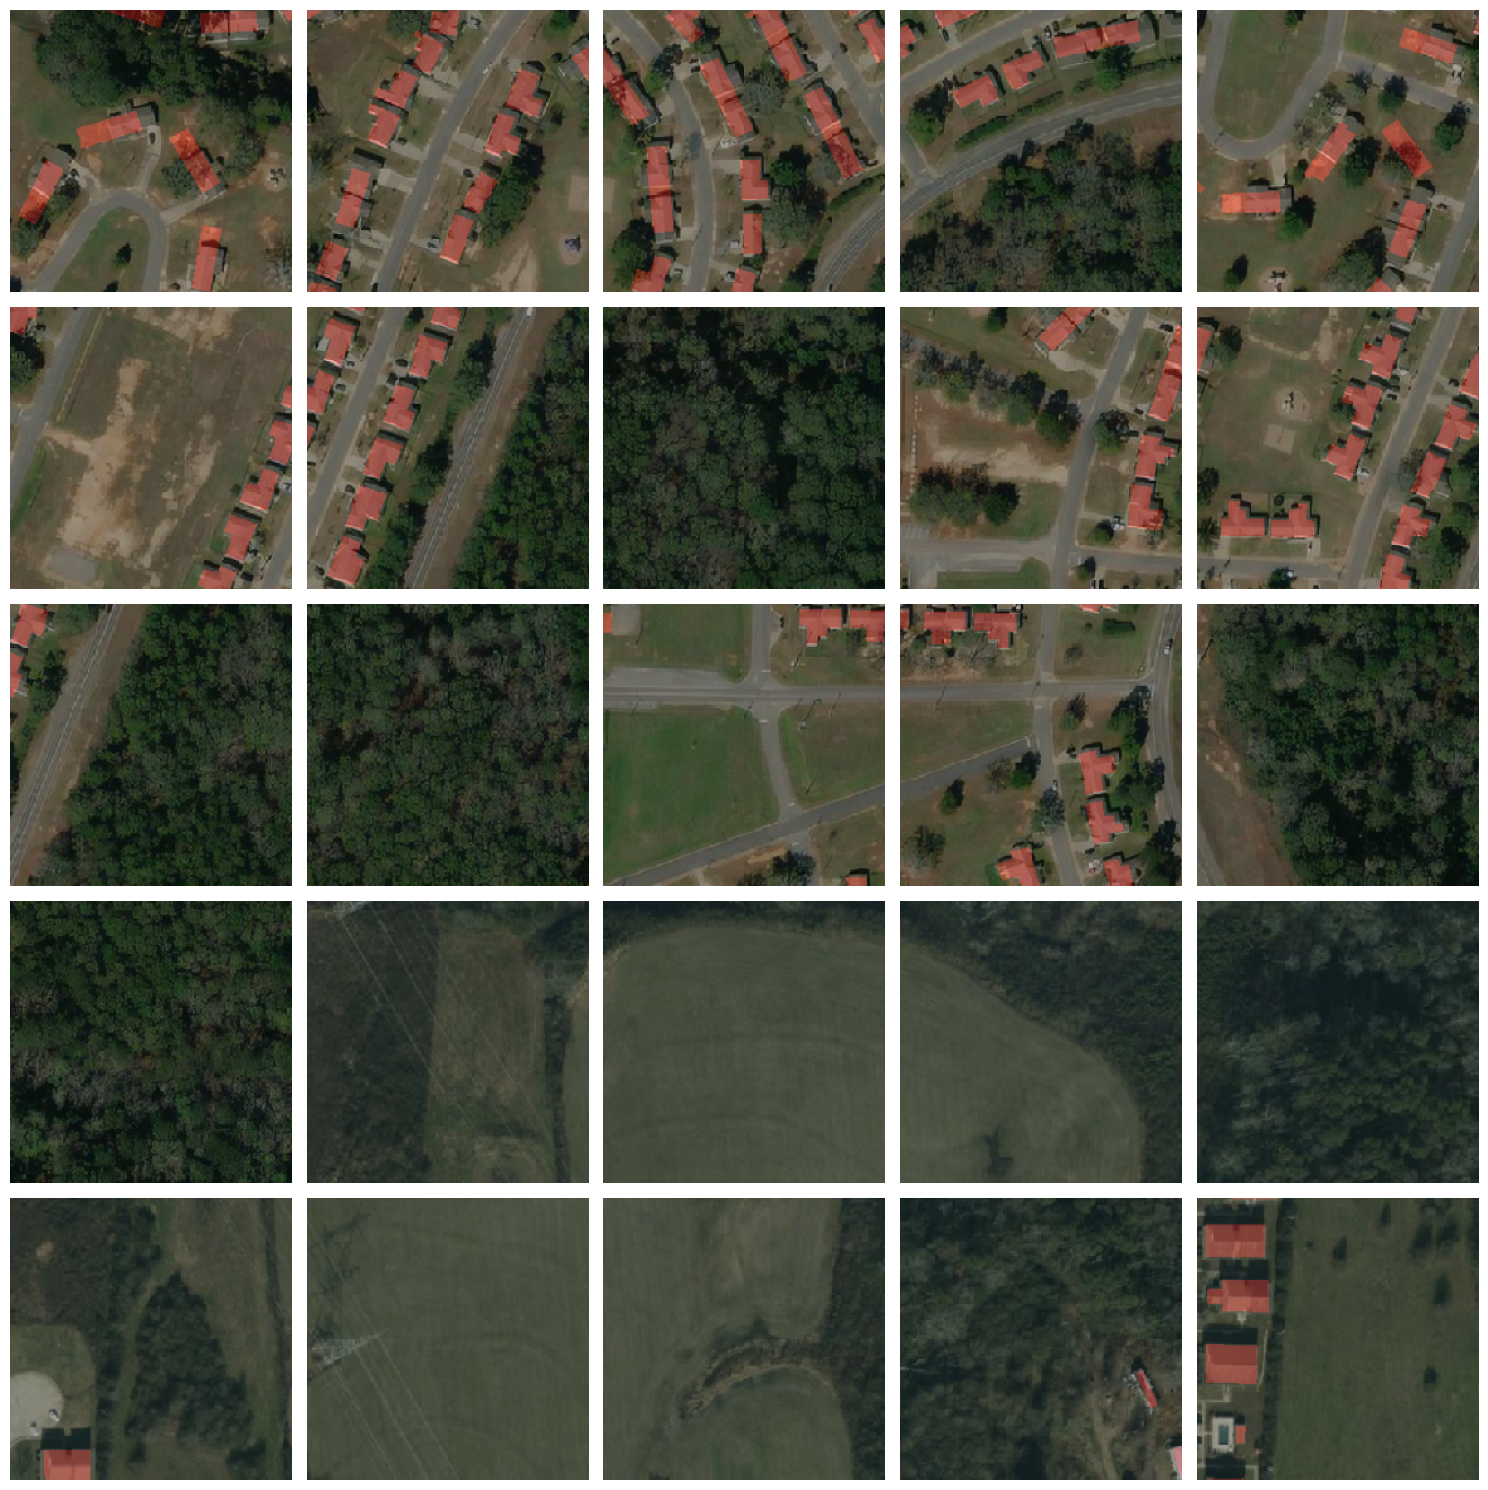

In [6]:
images, masks = [], []
for i in range(25):
    image, mask = dataset[i]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    images.append(image)
    masks.append(mask)

visualize_grid(images, masks)

In [7]:
train_transform = A.Compose(
    [
        A.Resize(224, 224, interpolation=cv2.INTER_NEAREST, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.4, border_mode=0),
        A.OneOf([
            A.OpticalDistortion(p=0.4),
            A.GridDistortion(p=0.1),
            A.IAAPiecewiseAffine(p=0.4)
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10, 15, 10),
            A.CLAHE(clip_limit=3),
            A.RandomBrightnessContrast(),
            A.Blur(blur_limit=3, p=0.5),
        ], p=0.4),
        A.OneOf([
            A.RandomGamma(),
            A.GaussNoise(),
            A.IAAAdditiveGaussianNoise(p=0.2),
        ], p=0.5),
        A.IAAPerspective(p=0.3),
        A.Normalize(),
        ToTensorV2()
    ], p=1.0)

valid_transform = A.Compose(
    [
        A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
        A.Normalize(),
        ToTensorV2()
    ], p=1.0)

train_dataset = SatelliteDataset(csv_file='./data/train_split.csv', transform=train_transform)
valid_dataset = SatelliteDataset(csv_file='./data/val_split.csv', transform=valid_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=96, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=valid_dataset, batch_size=96, shuffle=True, num_workers=4)

In [8]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, act=True):
        super().__init__()

        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_c)
        ]
        if act == True:
            layers.append(nn.ReLU(inplace=True))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

class multires_block(nn.Module):
    def __init__(self, in_c, out_c, alpha=1.67):
        super().__init__()

        W = out_c * alpha
        self.c1 = conv_block(in_c, int(W*0.167))
        self.c2 = conv_block(int(W*0.167), int(W*0.333))
        self.c3 = conv_block(int(W*0.333), int(W*0.5))

        nf = int(W*0.167) + int(W*0.333) + int(W*0.5)
        self.b1 = nn.BatchNorm2d(nf)
        self.c4 = conv_block(in_c, nf)
        self.relu = nn.ReLU(inplace=True)
        self.b2 = nn.BatchNorm2d(nf)

    def forward(self, x):
        x0 = x
        x1 = self.c1(x0)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        xc = torch.cat([x1, x2, x3], dim=1)
        xc = self.b1(xc)

        sc = self.c4(x0)
        x = self.relu(xc + sc)
        x = self.b2(x)
        return x

class res_path_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.c1 = conv_block(in_c, out_c, act=False)
        self.s1 = conv_block(in_c, out_c, kernel_size=1, padding=0, act=False)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_c)

    def forward(self, x):
        x1 = self.c1(x)
        s1 = self.s1(x)
        x = self.relu(x1 + s1)
        x = self.bn(x)
        return x

class res_path(nn.Module):
    def __init__(self, in_c, out_c, length):
        super().__init__()

        layers = []
        for i in range(length):
            layers.append(res_path_block(in_c, out_c))
            in_c = out_c

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

def cal_nf(ch, alpha=1.67):
    W = ch * alpha
    return int(W*0.167) + int(W*0.333) + int(W*0.5)

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c, length):
        super().__init__()

        self.c1 = multires_block(in_c, out_c)
        nf = cal_nf(out_c)
        self.s1 = res_path(nf, out_c, length)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        x = self.c1(x)
        s = self.s1(x)
        p = self.pool(x)
        return s, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.c1 = nn.ConvTranspose2d(in_c[0], out_c, kernel_size=2, stride=2, padding=0)
        self.c2 = multires_block(out_c+in_c[1], out_c)

    def forward(self, x, s):
        x = self.c1(x)
        x = torch.cat([x, s], dim=1)
        x = self.c2(x)
        return x

class build_multiresunet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 32, 5)
        self.e2 = encoder_block(cal_nf(32), 64, 4)
        self.e3 = encoder_block(cal_nf(64), 128, 3)
        self.e4 = encoder_block(cal_nf(128), 256, 2)
        self.e5 = encoder_block(cal_nf(256), 512, 1) # add layer

        """ Bridge """
        self.b1 = multires_block(cal_nf(512), 1024)
        #self.b1 = multires_block(cal_nf(256), 512)

        """ Decoder """
        self.d1 = decoder_block([cal_nf(1024), 512], 512) # add layer
        self.d2 = decoder_block([cal_nf(512), 256], 256)
        self.d3 = decoder_block([cal_nf(256), 128], 128)
        self.d4 = decoder_block([cal_nf(128), 64], 64)
        self.d5 = decoder_block([cal_nf(64), 32], 32)

        """ Output """
        self.output = nn.Conv2d(cal_nf(32), 1, kernel_size=1, padding=0)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        s5, p5 = self.e5(p4)

        b1 = self.b1(p5)

        d1 = self.d1(b1, s5)
        d2 = self.d2(d1, s4)
        d3 = self.d3(d2, s3)
        d4 = self.d4(d3, s2)
        d5 = self.d5(d4, s1)

        output = self.output(d5)
        return output

In [9]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.6, beta=0.4):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, preds, targets):
        bce_loss = F.binary_cross_entropy_with_logits(preds, targets)
        dice_loss = self.dice_loss(preds, targets)

        combined_loss = self.alpha * bce_loss + self.beta * dice_loss
        return combined_loss

    def dice_loss(self, preds, targets, smooth=1e-7):
        # sigmoid normalization
        preds = torch.sigmoid(preds)

        # flatten label and prediction tensors
        preds = preds.contiguous().view(-1)
        targets = targets.contiguous().view(-1)

        intersection = (preds * targets).sum()
        dice = (2.*intersection + smooth) / (preds.sum() + targets.sum() + smooth)

        return 1 - dice

In [10]:
def dice_coefficient(pred, target):
    smooth = 1.
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    coefficient = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return coefficient

In [11]:
# model 초기화
model = build_multiresunet().to(device)
model = nn.DataParallel(model)

# loss function과 optimizer 정의
criterion = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

In [12]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_dice = 0

    tqdm_bar = tqdm(dataloader, desc='Training')
    for images, masks in tqdm_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1).float())
        dice = dice_coefficient(outputs.sigmoid(), masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice.item()

        tqdm_bar.set_postfix({
            'Training Loss': f'{loss.item():.5f}', 
            'Training Dice': f'{dice.item():.5f}'
        })

    train_loss /= len(dataloader)
    train_dice /= len(dataloader)
    return train_loss, train_dice

def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    val_dice = 0

    tqdm_bar = tqdm(dataloader, desc='Validating')
    with torch.no_grad():
        for images, masks in tqdm_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1).float())
            dice = dice_coefficient(outputs.sigmoid(), masks)

            val_loss += loss.item()
            val_dice += dice.item()

            tqdm_bar.set_postfix({
                'Validation Loss': f'{loss.item():.5f}', 
                'Validation Dice': f'{dice.item():.5f}'
            })

    val_loss /= len(dataloader)
    val_dice /= len(dataloader)
    return val_loss, val_dice

In [13]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def inverse_normalize(img, mean, std):
    img_copy = img.copy()
    img_copy *= std
    img_copy += mean
    img_copy *= 255.0   # 이미지를 0-255 사이로 스케일링
    img_copy = img_copy.astype(np.uint8) # uint8로 변환
    return img_copy

In [ ]:
best_weights_path = 'multiresunet_224_patch_based.pth'

patience = 10
num_epochs = 1000

if os.path.exists(best_weights_path):
    # Load the checkpoint
    checkpoint = torch.load(best_weights_path)
    
    # Restore the model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Restore other training parameters and states
    best_val_loss = checkpoint['best_val_loss']
    early_stopping_counter = checkpoint['early_stopping_counter']
    start_epoch = checkpoint['epoch'] + 1
else:
    best_val_loss = float('inf')
    early_stopping_counter = 0
    start_epoch = 0
    
for epoch in range(start_epoch, num_epochs):
    train_loss, train_dice = train(model, train_loader, criterion, optimizer)
    val_loss, val_dice = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

    # Adjust learning rate
    scheduler.step(val_loss)
    
    # Save the weights of the model with lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch' : epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'best_val_loss' : best_val_loss,
            'early_stopping_counter' : early_stopping_counter,
        }
        torch.save(checkpoint, best_weights_path)
        early_stopping_counter = 0
        print('Saved Weights, Best Loss : ', best_val_loss)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break
'''
    # 5 에폭마다 원본 이미지와 예측 마스크 출력
    if (epoch + 1) % 3 == 0:
        model.eval()
        with torch.no_grad():
            images, masks = next(iter(val_loader))
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs).data.cpu().numpy()
            
        # 첫 번째 배치의 첫 번째 이미지 및 마스크 출력
        for i in range(4):
            plt.figure(figsize=(15, 5))
        
            # 원본 이미지
            plt.subplot(1, 2, 1)
            # normalization 되돌리기
            original_image = inverse_normalize(images[i].cpu().numpy().transpose((1, 2, 0)), mean, std)
            plt.imshow(original_image)
            plt.title('Original Image')
            plt.axis('off')
        
            # 예측 마스크
            plt.subplot(1, 2, 2)
            plt.imshow(outputs[i, 0, :, :], cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.show()
        model.train()
'''
print("Training finished.")

Validating: 100%|██████████| 60/60 [00:31<00:00,  1.88it/s, Validation Loss=0.21804, Validation Dice=0.62088]


Epoch 1/1000
Train Loss: 0.2828, Train Dice: 0.5438
Val Loss: 0.1603, Val Dice: 0.7218
Saved Weights, Best Loss :  0.16025851269563038


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.12844, Validation Dice=0.76429]


Epoch 2/1000
Train Loss: 0.1843, Train Dice: 0.6877
Val Loss: 0.1391, Val Dice: 0.7607
Saved Weights, Best Loss :  0.13911696809033552


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.14766, Validation Dice=0.76612]


Epoch 3/1000
Train Loss: 0.1667, Train Dice: 0.7181
Val Loss: 0.1331, Val Dice: 0.7736
Saved Weights, Best Loss :  0.13308843423922856


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.14354, Validation Dice=0.77085]


Epoch 4/1000
Train Loss: 0.1559, Train Dice: 0.7367
Val Loss: 0.1258, Val Dice: 0.7834
Saved Weights, Best Loss :  0.12575941098233065


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.12394, Validation Dice=0.78107]


Epoch 5/1000
Train Loss: 0.1499, Train Dice: 0.7472
Val Loss: 0.1195, Val Dice: 0.7933
Saved Weights, Best Loss :  0.11949610362450282


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.10589, Validation Dice=0.80446]


Epoch 6/1000
Train Loss: 0.1452, Train Dice: 0.7551
Val Loss: 0.1179, Val Dice: 0.7986
Saved Weights, Best Loss :  0.1179226382325093


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.13225, Validation Dice=0.77882]


Epoch 7/1000
Train Loss: 0.1400, Train Dice: 0.7639
Val Loss: 0.1123, Val Dice: 0.8066
Saved Weights, Best Loss :  0.11232725170751413


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.10363, Validation Dice=0.81330]


Epoch 8/1000
Train Loss: 0.1371, Train Dice: 0.7689
Val Loss: 0.1104, Val Dice: 0.8122
Saved Weights, Best Loss :  0.1104457372178634


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.88it/s, Validation Loss=0.10982, Validation Dice=0.80157]


Epoch 9/1000
Train Loss: 0.1348, Train Dice: 0.7728
Val Loss: 0.1197, Val Dice: 0.7957


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.12882, Validation Dice=0.78068]


Epoch 10/1000
Train Loss: 0.1330, Train Dice: 0.7756
Val Loss: 0.1055, Val Dice: 0.8210
Saved Weights, Best Loss :  0.10549256193141142


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.10465, Validation Dice=0.82568]


Epoch 11/1000
Train Loss: 0.1305, Train Dice: 0.7801
Val Loss: 0.1063, Val Dice: 0.8202


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.88it/s, Validation Loss=0.09949, Validation Dice=0.84521]


Epoch 12/1000
Train Loss: 0.1293, Train Dice: 0.7820
Val Loss: 0.1038, Val Dice: 0.8245
Saved Weights, Best Loss :  0.10382157936692238


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.88it/s, Validation Loss=0.10689, Validation Dice=0.83676]


Epoch 13/1000
Train Loss: 0.1266, Train Dice: 0.7867
Val Loss: 0.1029, Val Dice: 0.8227
Saved Weights, Best Loss :  0.10288051428894202


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.11811, Validation Dice=0.78803]


Epoch 14/1000
Train Loss: 0.1259, Train Dice: 0.7877
Val Loss: 0.1028, Val Dice: 0.8214
Saved Weights, Best Loss :  0.10281300532321135


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.08532, Validation Dice=0.84631]


Epoch 15/1000
Train Loss: 0.1246, Train Dice: 0.7902
Val Loss: 0.1023, Val Dice: 0.8249
Saved Weights, Best Loss :  0.10226610663036505


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.10943, Validation Dice=0.83654]


Epoch 16/1000
Train Loss: 0.1232, Train Dice: 0.7922
Val Loss: 0.0999, Val Dice: 0.8293
Saved Weights, Best Loss :  0.099926104520758


Validating: 100%|██████████| 60/60 [00:32<00:00,  1.86it/s, Validation Loss=0.07378, Validation Dice=0.87121]


Epoch 17/1000
Train Loss: 0.1222, Train Dice: 0.7940
Val Loss: 0.1003, Val Dice: 0.8281


Validating: 100%|██████████| 60/60 [00:32<00:00,  1.87it/s, Validation Loss=0.08141, Validation Dice=0.86231]


Epoch 18/1000
Train Loss: 0.1216, Train Dice: 0.7951
Val Loss: 0.0998, Val Dice: 0.8296
Saved Weights, Best Loss :  0.09979798259834448


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.08566, Validation Dice=0.83320]


Epoch 19/1000
Train Loss: 0.1192, Train Dice: 0.7992
Val Loss: 0.0969, Val Dice: 0.8336
Saved Weights, Best Loss :  0.09690460761388144


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.10661, Validation Dice=0.81449]


Epoch 20/1000
Train Loss: 0.1193, Train Dice: 0.7989
Val Loss: 0.0976, Val Dice: 0.8310


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.10310, Validation Dice=0.80341]


Epoch 21/1000
Train Loss: 0.1185, Train Dice: 0.8004
Val Loss: 0.0974, Val Dice: 0.8309


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.11319, Validation Dice=0.82203]


Epoch 22/1000
Train Loss: 0.1167, Train Dice: 0.8034
Val Loss: 0.0946, Val Dice: 0.8397
Saved Weights, Best Loss :  0.09462470772365729


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.10342, Validation Dice=0.81066]


Epoch 23/1000
Train Loss: 0.1179, Train Dice: 0.8013
Val Loss: 0.0992, Val Dice: 0.8300


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s, Validation Loss=0.08125, Validation Dice=0.88141]


Epoch 24/1000
Train Loss: 0.1165, Train Dice: 0.8036
Val Loss: 0.0941, Val Dice: 0.8380
Saved Weights, Best Loss :  0.0940946036328872


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.88it/s, Validation Loss=0.07758, Validation Dice=0.87487]


Epoch 25/1000
Train Loss: 0.1146, Train Dice: 0.8068
Val Loss: 0.0935, Val Dice: 0.8411
Saved Weights, Best Loss :  0.0935484824081262


Validating: 100%|██████████| 60/60 [00:31<00:00,  1.89it/s, Validation Loss=0.08740, Validation Dice=0.85032]


Epoch 26/1000
Train Loss: 0.1152, Train Dice: 0.8059
Val Loss: 0.0935, Val Dice: 0.8413
Saved Weights, Best Loss :  0.0934902623295784


Validating: 100%|██████████| 60/60 [00:32<00:00,  1.87it/s, Validation Loss=0.10093, Validation Dice=0.81752]


Epoch 27/1000
Train Loss: 0.1142, Train Dice: 0.8075
Val Loss: 0.0992, Val Dice: 0.8308


Training:  71%|███████   | 801/1131 [12:33<06:07,  1.11s/it, Training Loss=0.11646, Training Dice=0.80271]

In [13]:
class SatelliteTestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(os.path.join('./data', img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.medianBlur(image, 5)
        
        if self.transform:
            image = self.transform(image=image)['image']
        return image

In [17]:
model.load_state_dict(torch.load(best_weights_path))
test_dataset = SatelliteTestDataset(csv_file='./data/test.csv', transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

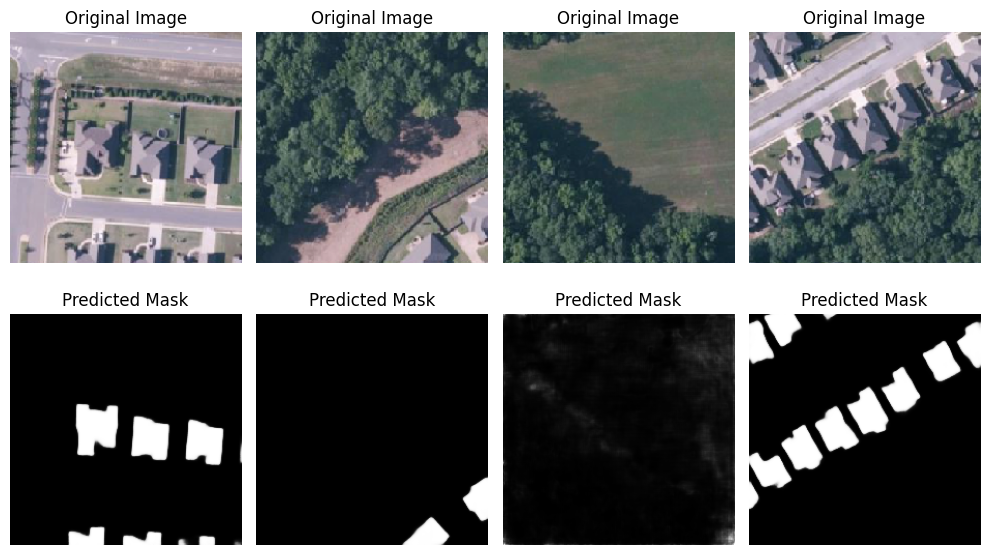

In [18]:
images = next(iter(test_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs).data.cpu().numpy()

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
for i in range(4):
    ax[0, i].imshow(inverse_normalize(images[i].cpu().numpy().transpose((1, 2, 0)), mean, std))
    ax[0, i].title.set_text('Original Image')
    ax[0, i].axis('off')

    ax[1, i].imshow(preds[i, 0, :, :], cmap='gray')
    ax[1, i].title.set_text('Predicted Mask')
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

In [28]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_loader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.5).astype(np.uint8)
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 474/474 [02:19<00:00,  3.40it/s]


In [29]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['mask_rle'] = result

In [30]:
submit.to_csv('./submit.csv', index=False)